In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import eli5
import xarray as xr
from eli5.sklearn import PermutationImportance
import os
from netCDF4 import Dataset
import cdo
import matplotlib.pyplot as plt

### Données brutes

In [4]:
path=os.getcwd()

In [7]:
print(path)

/Users/agathegentric/Desktop/INSA/IAF/defi_IA/defi_IA-main


In [ ]:
file1 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test1.csv'
file2 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test2.csv'
file3 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test3.csv'
file4 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test4.csv'
file5 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_test5.csv'
file6 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test7.csv'
file7 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_8.csv'
file8 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_9.csv'
file9 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_10.csv'
file10 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_11.csv'
file11 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_12.csv'

In [14]:
file1 = path+'/pricing_requests/pricing_requests_test1.csv'
file2 = path+'/pricing_requests/pricing_requests_test2.csv'
file3 = path+'/pricing_requests/pricing_requests_test3.csv'
file4 = path+'/pricing_requests/pricing_requests_test4.csv'
file5 = path+'/pricing_requests/pricing_test5.csv'
file6 = path+'/pricing_requests/pricing_requests_test7.csv'
#file7 = path+'/pricing_requests/pricing_requests_8.csv'
#file8 =path+ '/pricing_requests/pricing_requests_9.csv'
#file9 = path+'/pricing_requests/pricing_requests_10.csv'
#file10 = path+'/pricing_requests/pricing_requests_11.csv'
#file11 = path+'/pricing_requests/pricing_requests_12.csv'

In [16]:
file_list=[file1,file2,file3,file4,file5,file6]#,file7,file8
  
dataset = pd.DataFrame(pd.read_csv(file_list[0]))
  
for i in range(1,len(file_list)):
    data = pd.read_csv(file_list[i])
    df = pd.DataFrame(data)
    dataset = pd.concat([dataset,df])

In [17]:
dataset

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,amsterdam,14,dutch,0,59852,Morriott International,Corlton,1,1,0
1,442,190,19,amsterdam,14,dutch,0,59852,Accar Hotels,Marcure,0,0,0
2,588,173,0,amsterdam,14,dutch,0,59852,Independant,Independant,0,0,0
3,807,323,17,amsterdam,14,dutch,0,59852,Chillton Worldwide,Chill Garden Inn,0,1,0
4,271,81,0,amsterdam,14,dutch,0,59852,Independant,Independant,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,507,121,1,amsterdam,1,estonian,1,313004,Boss Western,Boss Western,0,0,0
9970,557,117,0,amsterdam,1,estonian,1,313004,Accar Hotels,Navatel,0,0,0
9971,157,386,1,amsterdam,1,estonian,1,313004,Morriott International,Corlton,0,0,0
9972,10,158,0,amsterdam,1,estonian,1,313004,Chillton Worldwide,Tripletree,0,0,0


<AxesSubplot:>

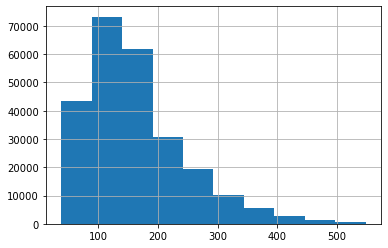

In [18]:
#on trace la distribution de la cible
dataset['price'].hist()

(array([37336., 36776., 25291., 32209., 25475., 16466., 22110., 16479.,
        15629., 21511.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <BarContainer object of 10 artists>)

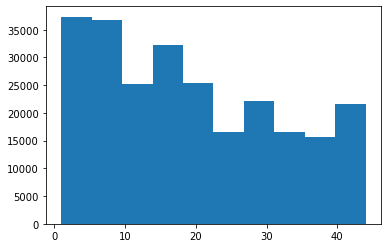

In [20]:
plt.hist(dataset['date'])

On essaye d'avoir un dataset proche de celui du test (voir plus loin).(? On essaye d'avoir une dataset d'entraînement la plus représentative possible des données pour permettre une bonne capacité de généralisation de notre modèle.) Pour cela, on commence par retirer du dataset les jours compris entre 8 et 12 et entre 24 et 32. (car nous pensons qu'il y a peu de différences dans les prix en sortie pour les valeurs de jours dans ces intervalles ?)

In [21]:
for i in range(8,13):
    dataset.drop(dataset[dataset.date == i].index, inplace=True)
for i in range(24,33):
    dataset.drop(dataset[dataset.date == i].index, inplace=True)

In [22]:
villes = dataset.groupby(['city'])['city'].count()
nom = villes.index
nbe= villes.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'ville': nom,

    'value': nbe,

})
df.sort_values(by=['value'],ascending=False)

,ville,value
0,amsterdam,14323
2,madrid,10757
8,vilnius,10046
3,paris,8852
1,copenhagen,8700
4,rome,6744
7,vienna,6451
5,sofia,3071
6,valletta,2546


(array([14267., 10879.,  4002., 16531., 12011.,  1685.,     0.,  3608.,
         2901.,  5606.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <BarContainer object of 10 artists>)

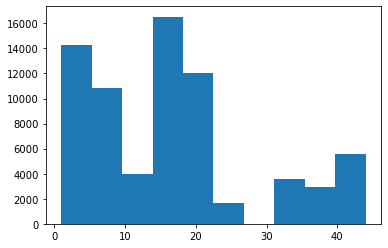

In [23]:
plt.hist(dataset['date'])

In [24]:
# langue :
langues = dataset.groupby(['language'])['language'].count()
nom = langues.index
nbe= langues.values
# langues = pd.DataFrame(langues)
# langues['language'§]
df = pd.DataFrame({

    'langue': nom,

    'value': nbe,


})
df.sort_values(by=['value'],ascending=False)

,langue,value
10,french,7291
19,maltese,6119
0,austrian,4589
25,spanish,4355
20,polish,4258
26,swedish,3874
6,danish,2795
2,bulgarian,2633
22,romanian,2599
3,croatian,2543


array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='stock', ylabel='price'>,
        <AxesSubplot:xlabel='date', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='stock'>,
        <AxesSubplot:xlabel='stock', ylabel='stock'>,
        <AxesSubplot:xlabel='date', ylabel='stock'>],
       [<AxesSubplot:xlabel='price', ylabel='date'>,
        <AxesSubplot:xlabel='stock', ylabel='date'>,
        <AxesSubplot:xlabel='date', ylabel='date'>]], dtype=object)

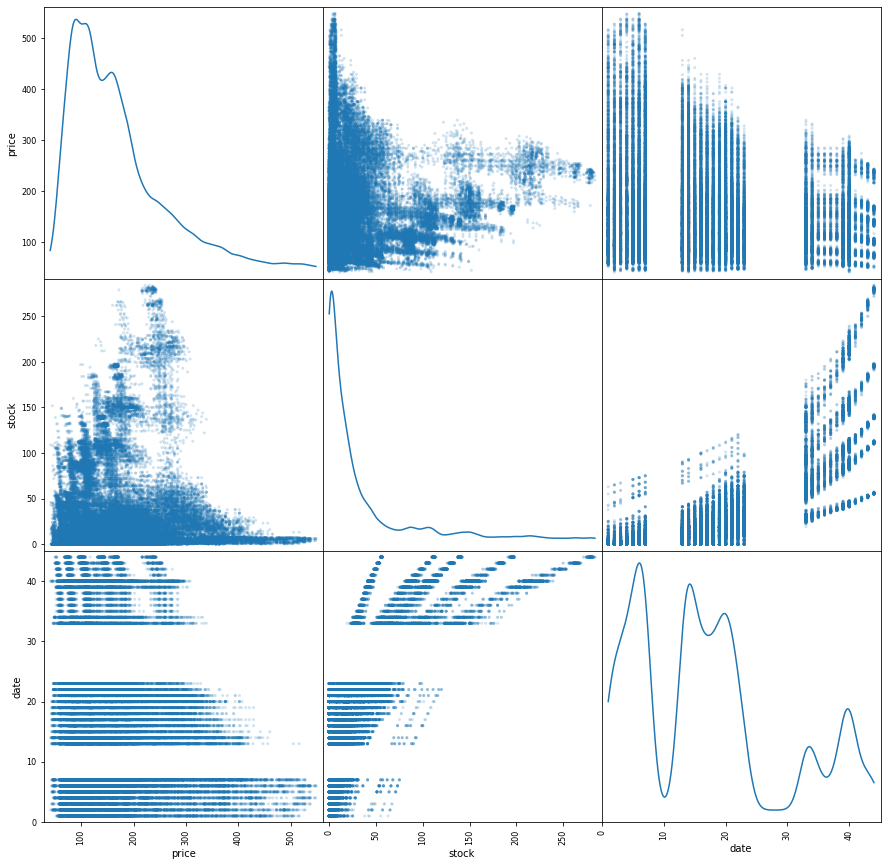

In [25]:
scatter_matrix(dataset[["price","stock","date"]], alpha=0.2, figsize=(15, 15), diagonal='kde')

### Données du test set

In [ ]:
# test sur le jeu de données test pour la soumission
file_test = '/home/enora/Documents/insa/IA/defi_IA-main/test_set.csv'
hotel_features = pd.read_csv('/home/enora/Documents/insa/IA/defi_IA-main/features_hotels.csv',index_col=['hotel_id', 'city'])

dataset_test = pd.DataFrame(pd.read_csv(file_test,index_col=0))
X_dataset_test= dataset_test.drop(labels=['order_requests'], axis=1)
X_dataset_test = X_dataset_test.join(hotel_features, on=['hotel_id', 'city'])
X_dataset_test.head()

In [ ]:
# test sur le jeu de données test pour la soumission
file_test = path+'/test_set.csv'
hotel_features = pd.read_csv(path+'/features_hotels.csv',index_col=['hotel_id', 'city'])

dataset_test = pd.DataFrame(pd.read_csv(file_test,index_col=0))
X_dataset_test= dataset_test.drop(labels=['order_requests'], axis=1)
X_dataset_test = X_dataset_test.join(hotel_features, on=['hotel_id', 'city'])
X_dataset_test.head()

Lorsqu'on crée notre jeu de données, nous pouvons agir sur la ville, la langue, l'avatar, la date, le mobile. Nous allons ainsi regarder plus précisemment ces variables du test set afin d'agrandir notre jeu de données de façon ciblée.

In [ ]:
# Date :
plt.hist(X_dataset_test.date)

On remarque que les dates comprises entre J0 et J-7 sont majoritaires, nous avons également un certain nombre de "demandes" pour des dates entre J-12 et J-24 puis entre J-32 et J-40. 

In [ ]:
# langue :
langues = X_dataset_test.groupby(['language'])['language'].count()
nom = langues.index
nbe= langues.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'langue': nom,

    'value': nbe,


})
df.sort_values(by=['value'],ascending=False)

On se rend compte que certaines langues sont bien plus utilisées que d'autres. On va donc agrandir notre jeu de données en se concentrant sur ces langues ci : hungarian, finnish, austrian, romanian, slovakian, swedish, estonian, bulgarian et danish.

In [ ]:
# ville :
villes = X_dataset_test.groupby(['city'])['city'].count()
nom = villes.index
nbe= villes.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'ville': nom,

    'value': nbe,

})
df.sort_values(by=['value'],ascending=False)

Les villes les plus représentées sont : Amsterdam, Paris et Madrid

In [ ]:
#mobile
plt.hist(X_dataset_test.mobile)

La différence entre le téléphone et l'ordinateur n'est pas très grande, on peut continuer à choisir aléatoirement

### Préparation des données
Dans cette partie on transforme les variables qualitatives en les encodant de deux manières différentes : avec One Hot Encoder et avec Target Encoder

##### encodage avec OneHotEncoder

L'encodage one-hot ou encodage 1-parmi-n consiste à encoder une variable à n états sur n bits dons un seul prend la valeur 1, le numéro du bit valant 1 étant le numéro de l'état pris par la variable.

source :  https://fr.wikipedia.org/wiki/Encodage_one-hot

In [35]:
# Variables explicatives

from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(dataset[["city","language","group","brand"]]).toarray())
df_ohe=dataset.join(enc_data)
one_hot_encoded_data = pd.get_dummies(dataset, columns = ["city","language","group","brand"])

X_ohe = one_hot_encoded_data.drop(labels='price',axis=1)
Y_ohe = one_hot_encoded_data.price

On observe les corrélations 

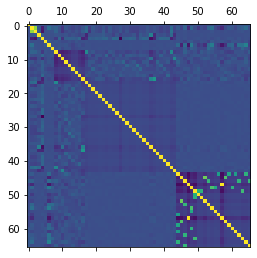

In [28]:
X_ohe.corr()
plt.matshow(X_ohe.corr())
plt.show()

FAIRE UN COMMENTAIRE

##### encodage avec Target Encoder


In [29]:
dict_city =  dataset.groupby('city')['price'].mean().to_dict()
dict_language = dataset.groupby('language')['price'].mean().to_dict()
dict_brand = dataset.groupby('brand')['price'].mean().to_dict()
dict_group = dataset.groupby('group')['price'].mean().to_dict()

In [37]:
from category_encoders.target_encoder import TargetEncoder
encoder = TargetEncoder()

/opt/anaconda3/envs/IA/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/anaconda3/envs/IA/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [38]:
dataset_targ = dataset

In [39]:
dataset_targ['city']=encoder.fit_transform(dataset_targ['city'],dataset_targ['price'])
dataset_targ['language']=encoder.fit_transform(dataset_targ['language'],dataset_targ['price'])
dataset_targ['brand']=encoder.fit_transform(dataset_targ['brand'],dataset_targ['price'])
dataset_targ['group']=encoder.fit_transform(dataset_targ['group'],dataset_targ['price'])

In [40]:
dataset_targ

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,172.639461,14,159.102833,0,59852,233.325087,295.937389,1,1,0
1,442,190,19,172.639461,14,159.102833,0,59852,196.246150,204.349325,0,0,0
2,588,173,0,172.639461,14,159.102833,0,59852,98.428777,98.428777,0,0,0
3,807,323,17,172.639461,14,159.102833,0,59852,228.501213,309.814564,0,1,0
4,271,81,0,172.639461,14,159.102833,0,59852,98.428777,98.428777,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,867,154,0,172.639461,4,163.264774,0,313004,98.428777,98.428777,1,0,0
3948,567,95,0,172.639461,4,163.264774,0,313004,98.428777,98.428777,1,0,0
3949,891,128,4,172.639461,4,163.264774,0,313004,98.428777,98.428777,1,0,0
3950,101,415,4,172.639461,4,163.264774,0,313004,196.246150,309.586381,1,0,0


In [41]:
X_target = dataset_targ.drop(labels='price',axis=1)
Y_target = dataset_targ.price

### Extraction des échantillons apprentissage et test

In [43]:
# Avec l'encodage OneHotEncoding
from sklearn.model_selection import train_test_split  
X_train,X_test,Y_train,Y_test=train_test_split(X_ohe,Y_ohe,test_size=0.1)

In [44]:
# Avec l'encodage Target Encoding
from sklearn.model_selection import train_test_split  
X_train,X_test,Y_train,Y_test=train_test_split(X_target,Y_target,test_size=0.1)

### Modèle random forest

In [45]:
rf = RandomForestRegressor(max_depth=10)

In [46]:
rf.fit(X_train, Y_train)
print(f"Random forest score: {rf.score(X_test, Y_test):.2f}")

Random forest score: 0.97


### Modèle XGBoost

In [48]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [49]:
xgb.fit(X_train,Y_train)
print(f"XGBoost score: {xgb.score(X_test, Y_test):.2f}")

XGBoost score: 0.99


### Feature Importance

On trace les features par ordre d'importance pour les deux modèles testés (random forest et XGBoost)

In [50]:
feature_names = list(X_ohe.columns.values)
#feature_names

In [52]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf,xgb], ['random forest','XGBoost']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test, Y_test)
    features_importance = {'Feature_name':feature_names, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:20])
    plt.title(name)

ValueError: All arrays must be of the same length

<Figure size 432x288 with 0 Axes>

On regroupe les features par catégories 

In [53]:
features_importance_dict['random forest']
Feature_name = features_importance_dict['random forest']['Feature_name'].tolist()
Importance = features_importance_dict['random forest']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2 = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2[0]=Importance2[0]+Importance[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2[1]=Importance2[1]+Importance[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2[2]=Importance2[2]+Importance[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2[3]=Importance2[3]+Importance[i]  

for j in range(4,len(Feature_name2)):
    Importance2[j]= Importance[Feature_name.index(Feature_name2[j])]     
        
Importance2      
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2)),columns =['Feature_name2', 'Importance2'])
features_importance2


KeyError: 'random forest'

In [54]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('Random forest');

NameError: name 'features_importance2' is not defined

Parking, language, children_policy, avatar_id, mobile n'ont pas d'importance 

In [ ]:
features_importance_dict['XGBoost']
Feature_name = features_importance_dict['XGBoost']['Feature_name'].tolist()
Importance_xgb = features_importance_dict['XGBoost']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2_xgb = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2_xgb[0]=Importance2_xgb[0]+Importance_xgb[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2_xgb[1]=Importance2_xgb[1]+Importance_xgb[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2_xgb[2]=Importance2_xgb[2]+Importance_xgb[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2_xgb[3]=Importance2_xgb[3]+Importance_xgb[i]  

for j in range(4,len(Feature_name2)):
    Importance2_xgb[j]= Importance_xgb[Feature_name.index(Feature_name2[j])]     
        
Importance2_xgb   
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2_xgb)),columns =['Feature_name2', 'Importance2_xgb'])
features_importance2


In [ ]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2_xgb']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('XGBoost');

De même, Parking, language, children_policy, avatar_id, mobile n'ont pas d'importance 

### Code pour la soumission

In [ ]:
# test sur le jeu de données test pour la soumission
file_test = '/home/enora/Documents/insa/IA/defi_IA-main/test_set.csv'
hotel_features = pd.read_csv('/home/enora/Documents/insa/IA/defi_IA-main/features_hotels.csv',index_col=['hotel_id', 'city'])

dataset_test = pd.DataFrame(pd.read_csv(file_test,index_col=0))
X_dataset_test= dataset_test.drop(labels=['order_requests'], axis=1)
X_dataset_test = X_dataset_test.join(hotel_features, on=['hotel_id', 'city'])

In [ ]:
X_dataset_test

In [ ]:
# Variables explicatives

#encodage avec OneHotEncoder

enc_data_test=pd.DataFrame(enc.fit_transform(X_dataset_test[["city","language","group","brand"]]).toarray())
df_test_ohe=dataset.join(enc_data_test)
one_hot_encoded_data_test = pd.get_dummies(X_dataset_test, columns = ["city","language","group","brand"])


In [ ]:
one_hot_encoded_data_test

In [ ]:
one_hot_encoded_data_test_reorder = one_hot_encoded_data_test[np.array(X_ohe.columns)] # on réarrange les colonnes de sorte à ce qu'elles soient dans le même ordre que pour l'entrainement
one_hot_encoded_data_test_reorder

In [ ]:
#encodage avec target encoder
city_encoding=[]
language_encoding=[]
group_encoding=[]
brand_encoding=[]

for i in X_dataset_test['city']:
    city_encoding.append(dict_city[str(i)])
for i in X_dataset_test['language']:
    language_encoding.append(dict_language[str(i)])
for i in X_dataset_test['group']:
    group_encoding.append(dict_group[str(i)])
for i in X_dataset_test['brand']:
     brand_encoding.append(dict_brand[str(i)])
        

In [ ]:
X_dataset_test['city_enc']=city_encoding
X_dataset_test['language_enc']=language_encoding
X_dataset_test['group_enc']=group_encoding
X_dataset_test['brand_enc']=brand_encoding


In [ ]:
del X_dataset_test['city']
del X_dataset_test['language']
del X_dataset_test['group']
del X_dataset_test['brand']

In [ ]:
X_dataset_test

In [ ]:
X_dataset_test_rename = X_dataset_test.rename(columns={"city_enc": "city", "language_enc": "language", "group_enc":"group", "brand_enc":"brand"})
X_dataset_test_rename


In [ ]:
X_dataset_test_reorder = X_dataset_test_rename[np.array(X_test.columns)] #labels dans le bon ordre

In [ ]:
X_dataset_test_reorder

In [ ]:
y_pred = xgb.predict(X_dataset_test_reorder)
y_pred=pd.DataFrame(y_pred)
y_pred.to_csv("submission12.csv")